In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

# 1. Трюки для обучения моделей

## Кросс-валидация (Cross-validation)

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
X,y = make_moons(n_samples=400, noise=0.2, random_state=12)

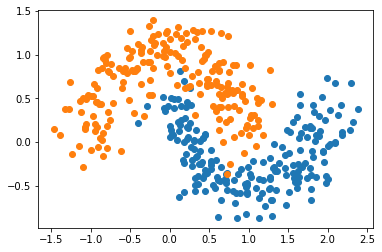

In [ ]:
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

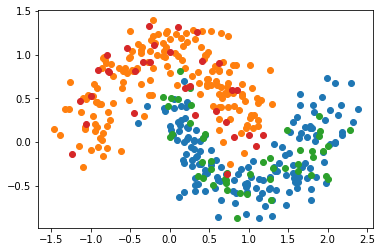

In [ ]:
plt.scatter(X_train[:,0][y_train==1], X_train[:,1][y_train==1])
plt.scatter(X_train[:,0][y_train==0], X_train[:,1][y_train==0])
plt.scatter(X_test[:,0][y_test==1], X_test[:,1][y_test==1])
plt.scatter(X_test[:,0][y_test==0], X_test[:,1][y_test==0])
plt.show()

#### Простое предсказание без кросс-валидации

In [ ]:
model = SVC(kernel='rbf')
model.fit(X_train,y_train)

SVC()

In [ ]:
y_pred = model.predict(X_train)
loss = accuracy_score(y_train, y_pred)
print("Train score: {:.4}".format(loss))
y_pred = model.predict(X_test)
loss = accuracy_score(y_test, y_pred)
print("Test score: {:.4}".format(loss))


Train score: 0.9844
Test score: 0.925


#### Подключим кросс валидацию на 5 фолдов

In [ ]:
num_folds = 5
model = SVC()
score = cross_val_score(model, X, y, cv=num_folds, scoring='accuracy')
print('CrossVal score: ', score)
print('Mean score: {:.4}'.format(score.mean()))

CrossVal score:  [0.95   0.9875 0.95   0.975  0.9875]
Mean score: 0.97


## Поиск по сетке (Grid search)

У моделей есть важные гиперпараметры, которые лень искать руками. Для этого используется Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = SVC(kernel='rbf')

params = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'gamma': [0.1, 0.2, 0.5]
}

In [ ]:
grid = GridSearchCV(model, params, scoring='accuracy', cv=5, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'gamma': [0.1, 0.2, 0.5]},
             scoring='accuracy')

In [ ]:
print('Best params:', grid.best_params_)
print('Best score:', grid.best_score_)

Best params: {'C': 10.0, 'gamma': 0.5}
Best score: 0.975


In [ ]:
final_model = grid.best_estimator_
y_pred = final_model.predict(X_test)
loss = accuracy_score(y_test, y_pred)
print("Final score: {:.4}".format(loss))

Final score: 0.9375


# 2. Решающие деревья (Decision Trees)

Дерево решений как алгоритм машинного обучения – по сути объединение логических правил вида "Значение признака $a$ меньше $x$ и значение признака $b$ меньше $y$ => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку.

## Простой пример дерева - сортировка шариков на синие и желтые

![Decision Tree](https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png)

Задача может стоять так: нужно по координате $X$ определить цвет шара. Здесь мы на каждом шаге принимаем решение о том, как выбрать границу раздела между шариками так, чтобы получившиеся в результате наборы были максимально "чистыми" с точки зрения цвета. Попробуем смоделировать процесс, изображенный на картинке, с помощью решающего дерева из библиотеки `sklearn`

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

In [ ]:
X = np.arange(0, 20).reshape(-1,1)
y = [0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1]

Обучим дерево на данных и воспользуемся функцией `export_text` для визуализации процесса принятия решений деревом

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X,y)

DecisionTreeClassifier()

In [ ]:
print(export_text(clf))

|--- feature_0 <= 12.50
|   |--- feature_0 <= 8.50
|   |   |--- feature_0 <= 4.50
|   |   |   |--- feature_0 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- feature_0 >  4.50
|   |   |   |--- class: 0
|   |--- feature_0 >  8.50
|   |   |--- class: 1
|--- feature_0 >  12.50
|   |--- feature_0 <= 18.50
|   |   |--- class: 0
|   |--- feature_0 >  18.50
|   |   |--- class: 1



Видно, что границы принятия решений деревом практически идентичны тем, что указаны на картинке. Разница в том, что в примере дерево работало с целочисленными границами, а здесь такого ограничения не было.

## Принятие решений деревом

Чтобы рассмотреть работу дерева на более приближенном к жизни примере, рассмотрим датасет iris.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Это набор данных о цветах, ирисах, которые в зависимости от своей геометрии подразделяются на 3 вида: Iris-Setosa, Iris-Versicolour и Iris-Virginica. Предположим, что мы нашли цветок ириса, и нам пришло в голову понять, к какому из трех классов он относится. Решающее дерево в данном случае будет отражать нашу логику в принятии данного решения.

Посмотрим, какие признаки есть у цветков:

In [ ]:
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [ ]:
X = iris.data[:, 2:] # Будем классифицировать по длине и ширине лепестков (petal)
y = iris.target
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [ ]:
print(export_text(clf, feature_names=iris.feature_names[2:],))

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- class: 1
|   |--- petal width (cm) >  1.75
|   |   |--- class: 2



Таким образом, мы видим, что если длина лепестков <= 2.45 см, то это class_0, т.е. Iris-Setosa. А иначе, очевидно, либо Iris-Versicolor, либо Iris-Virginica.

## Алгоритм CART

В принятии решений о выборе пары (признак, пороговое значение), по которым лучше всего разделить набор данных на два подмножества, деревья в `sklearn.tree` используют алгоритм CART (Classification And Regression Tree). В соответствии с ним, наилучшим признается такое разбиение набора, которое создает наиболее "чистые" подмножества с точки зрения количества входящих в них классов. Другими словами, если нам удалось найти такую длину лепестка ириса, меньше которой все ирисы с такими лепестками однозначно будут вида Iris-Setosa, то мы создали идеально "чистое" подмножество: в нем есть только один класс.

Loss-функция алгоритма CART 

$$J(k, t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right} $$

где $m_{l,r}$ - число элементов, вошедших в каждое из подмножеств, $m$- число элементов в исходном наборе, G - мера "чистоты" подмножества, $k$ - признак, а $t_k$ - пороговое значение, по которому элементы будут разделены.

В качестве меры чистоты в деревьях используется либо индекс Джинни $G$, либо энтропия Шеннона $H$. Они равны 0, если класс чист и принимают максимальное значение при равномерном распределении элементов по классам: (напр. 1/2, 1/2, либо 1/3, 1/3, 1/3)

$$G = 1 - \sum_{k=1}^{n} (p_k)^2, \ \quad \ H = -\sum_{k=1}^{n} p_k log_2 p_k, \ p_k \ne 0$$

Посмотрим на то, как дерево отработает на классификации в датасете `make_moons`

In [ ]:
X,y = make_moons(n_samples=400, noise=0.2, random_state=12)

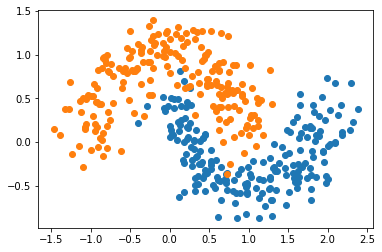

In [ ]:
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

In [ ]:
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)

In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
x1s = np.linspace(-1.5, 2.5, 100)
x2s = np.linspace(-1.0, 1.5, 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)

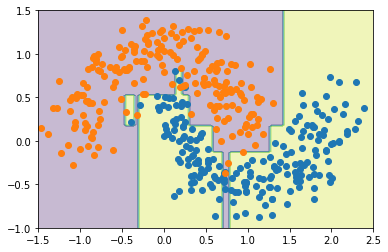

In [ ]:
plt.contourf(x1, x2, y_pred, alpha=0.3)
plt.scatter(X[:,0][y==1], X[:,1][y==1])
plt.scatter(X[:,0][y==0], X[:,1][y==0])
plt.show()

Видно, что дерево, предоставленное само себе, сильно переобучается. Рассмотрим, какие существуют подходы для регуляризации дерева.

## Регуляризация

### Введение максимальной глубины дерева

Мы можем ограничить дерево в глубине, т.е. ввести максимальную длину цепочки принятия решений.

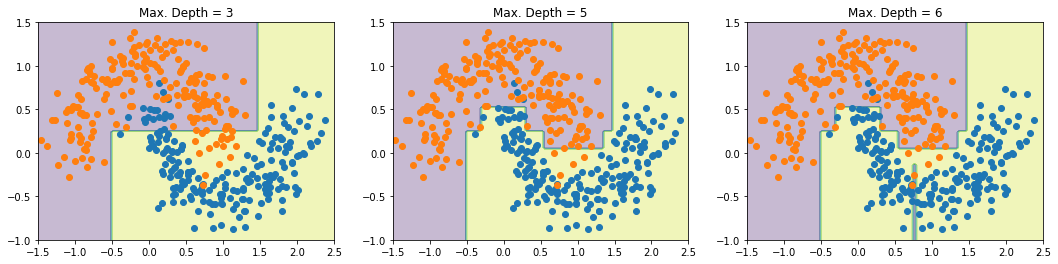

In [ ]:
depth_list = [3, 5, 6]
fig = plt.figure(figsize=(18,4))
for i, depth in enumerate(depth_list):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, y)
    plt.subplot(131 + i)
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    plt.scatter(X[:,0][y==1], X[:,1][y==1])
    plt.scatter(X[:,0][y==0], X[:,1][y==0])
    plt.title('Max. Depth = {}'.format(depth))
plt.show()
    
    

В данном примере видно, что дерево с максимальной глубиной 5 неплохо описывает выборку точек и не переобучается, в отличие от дерева с глубиной 6.

### Введение минимального количества объектов в "листьях" дерева

Мы также можем заставить дерево заканчивать делать разбиения, если на его краях (край, лист = финальное в принятии решений подмножество объектов, которое далее уже не разбивается) остается менее определенного количества элементов. Иначе дерево может переобучиться настолько, что придумает отдельное правило классификации для каждого объекта.

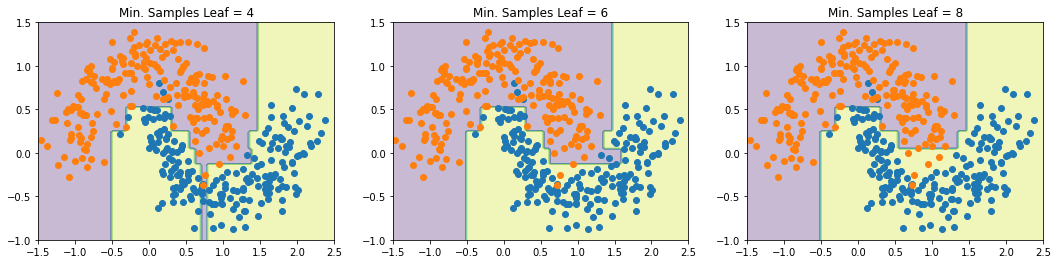

In [ ]:
samples_leaf_list = [4,6,8]
fig = plt.figure(figsize=(18,4))
for i, num_samples in enumerate(samples_leaf_list):
    clf = DecisionTreeClassifier(min_samples_leaf=num_samples)
    clf.fit(X, y)
    plt.subplot(131 + i)
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    plt.scatter(X[:,0][y==1], X[:,1][y==1])
    plt.scatter(X[:,0][y==0], X[:,1][y==0])
    plt.title('Min. Samples Leaf = {}'.format(num_samples))
plt.show()
    
    

Также существуют и другие методы регуляризации дерева:

- min_samples_split - мин. количество объектов в узле дерева, необходимое для разбиения
- min_weight_fraction_leaf - то же, что min_samples_leaf, только выраженное в долях от полного числа объектов
- max_leaf_nodes - макс. число листьев
- ... и т.д.

## Регрессия на решающих деревьях 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_text

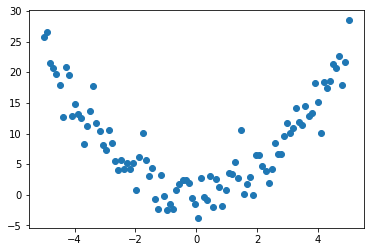

In [ ]:
N = 100
x = np.linspace(-5.0, 5.0, N)
y = x**2 + np.random.normal(scale=2.5, size=N)
plt.scatter(x,y)
plt.show()

In [ ]:
reg = DecisionTreeRegressor(max_depth=3)
reg.fit(x.reshape(N,1),y)
y_pred = reg.predict(x.reshape(N,1))

### Дерево пытается приблизить исходный набор точек кусочно-постоянной функцией

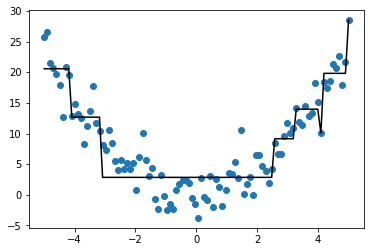

In [ ]:
plt.scatter(x,y)
plt.plot(x, y_pred, 'k')
plt.show()

In [ ]:
print(export_text(reg))

|--- feature_0 <= 3.23
|   |--- feature_0 <= -3.13
|   |   |--- feature_0 <= -4.14
|   |   |   |--- value: [20.59]
|   |   |--- feature_0 >  -4.14
|   |   |   |--- value: [12.68]
|   |--- feature_0 >  -3.13
|   |   |--- feature_0 <= 2.53
|   |   |   |--- value: [2.85]
|   |   |--- feature_0 >  2.53
|   |   |   |--- value: [9.16]
|--- feature_0 >  3.23
|   |--- feature_0 <= 4.14
|   |   |--- feature_0 <= 4.04
|   |   |   |--- value: [13.99]
|   |   |--- feature_0 >  4.04
|   |   |   |--- value: [10.10]
|   |--- feature_0 >  4.14
|   |   |--- feature_0 <= 4.95
|   |   |   |--- value: [19.84]
|   |   |--- feature_0 >  4.95
|   |   |   |--- value: [28.51]



### Подберем параметры с помощью GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
params = {
    'max_depth': [3,4,5,6,7],
    'min_samples_leaf': [2,3,4,5]
}
gs = GridSearchCV(DecisionTreeRegressor(), params, n_jobs=4, cv=5)

In [ ]:
gs.fit(x.reshape(N,1),y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [2, 3, 4, 5]})

In [ ]:
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 2}

In [ ]:
reg = DecisionTreeRegressor(max_depth=6, min_samples_leaf=2)
reg.fit(x.reshape(N,1),y)
y_pred = reg.predict(x.reshape(N,1))

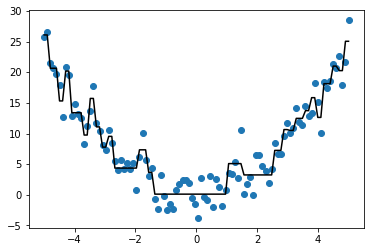

In [ ]:
plt.scatter(x,y)
plt.plot(x, y_pred, 'k')
plt.show()

### Большой минус деревьев: они валятся на экстраполяции



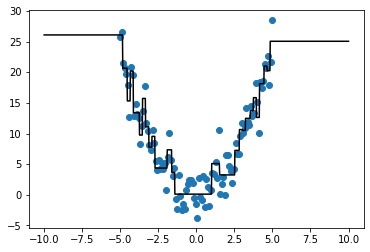

In [ ]:
x_new = np.linspace(-10.0, 10.0, 1000)
y_pred = reg.predict(x_new.reshape(1000,1))
plt.scatter(x,y)
plt.plot(x_new, y_pred, 'k')
plt.show()

# 3. Задание: Решающие деревья на датасете Steels Kaggle

Итак, твое задание состоит в следующем:
1. Построй регрессор на основе решающего дерева.
2. Обучи модель для предсказания `0.2% Proof Stress (MPa)` по составу стали и температуре. Используй `StandardScaler` для скейлинга признаков. Влияет ли его наличие на качество модели? Попробуй объяснить результат. 
3. С помощью кросс-валидации и поиска по сетке найди оптимальные параметры для:
  * Максимальной глубины дерева `max_depth`
  * Минимального количества объектов в листьях дерева `min_samples_leaf`
  * Минимального количества объектов в узле дерева, необходимого для разбиения `min_samples_split`
  * Максимального числа листьев `max_leaf_nodes`
4. Постарайся достигнуть наименьшей ошибки на кросс валидации. Какая комбинация параметров дает наименьшую ошибку? Удается ли превзойти модели линейной регрессии и метода опорных векторов?

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse

In [ ]:
data = pd.read_csv('Steels_kaggle.csv')
data_work = data[data.columns[1:17]] #датасет с нужными колонками
data_work.head()

"Проведем стандартизацию данных" 
scaler = StandardScaler()
features = data_work.drop(' 0.2% Proof Stress (MPa)', axis=1)
target = data_work[' 0.2% Proof Stress (MPa)']

X_scaled = scaler.fit_transform(features)

Вообще, скейлинг не должен влиять на результат в решающем дереве, поскольку деление в дереве происходит по каждому признаку и ему не очень важно имеено скейлинг.

In [ ]:
#разделим данные на train и test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.2)

In [ ]:
params = {'max_depth': np.arange(2, 30),
          'min_samples_leaf':[2, 4, 6, 8, 10, 12, 14],
          'min_samples_split':[2, 4, 6, 8, 10],
          'max_leaf_nodes':np.arange(2, 100, 10)}

In [ ]:
grid = GridSearchCV(DecisionTreeRegressor(), params, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'max_leaf_nodes': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]),
                         'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
grid.best_params_

{'max_depth': 13,
 'max_leaf_nodes': 92,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [ ]:
y_pred = grid.predict(X_test)
err = mse(y_test, y_pred)
print('MSE = ', err)

MSE =  1687.741211888603


Text(0, 0.5, 'y_pred')

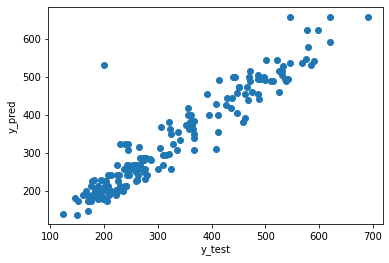

In [ ]:
plt.plot(y_test, y_pred, 'o')
plt.xlabel('y_test')
plt.ylabel('y_pred')

Модель решающего дерева обходит по mse обычную линейную регрессию. Она уступает полиномиальной регрессии с регуляризацией где для разных моделей регуляризации MSE был ~700. 

Модель решающего дерева обходит по метрике качества метод опорных векторов в случае линейного ядра, но уступает в качестве моделям с полимиальным ядром и гауссовским ядром.